In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def one_hot_encode(y):
    N = len(y)
    K = len(set(y))
    
    Y = np.zeros((N,K))
    
    for i in range(N):
        Y[i,y[i]] = 1
        
    return Y

def shuffle(*args):
    idx = np.random.permutation(len(args[0]))
    return [X[idx] for X in args]

def ReLU(H):
    return H*(H > 0)

def softmax(H):
    eH = np.exp(H)
    return eH/eH.sum(axis = 1, keepdims = True)

def feed_forward(X,W1,b1,W2,b2):
    Z1 = ReLU(np.matmul(X,W1) + b1)
    P_hat = softmax(np.matmul(Z1,W2) + b2)
    return Z1, P_hat
    
def cross_entropy(Y, P_hat):
    return -np.sum(Y*np.log(P_hat))

def accuracy(y, p_hat):
    return np.mean(y == p_hat.argmax(axis=1))

In [4]:
data=pd.read_csv("usps_digit_recognizer.csv")
d=data.label
data=data/255
data.label=d

G=[data.iloc[i,1:].mean() for i in range(len(data.label))] #average of the whole digit to measure the amount of ink used
G5=[data.iloc[i,393:].mean() for i in range(len(data.label))] #average ink for the bottom half

l2=[x for x in range(28*0,28*6-1,1)]
l3=[x for x in range(28*6,28*14-1,1)]
l4=[x for x in range(28*14,28*21-1,1)]
G2=[data.iloc[i,l2].mean() for i in range(len(data.label))]#average pixels 1/4 way line across the image 
G3=[data.iloc[i,l3].mean() for i in range(len(data.label))]
G4=[data.iloc[i,l4].mean() for i in range(len(data.label))]

data['Ave_pix']=G
data['G5']=G5
data['Gl4']=G4
data['Gl2']=G2
data['Gl3']=G3

#partitioning to do cross validation
train=data.sample(frac=0.6,random_state=0)
temp=data.loc[~data.index.isin(train.index),:]
validation=temp.sample(frac=0.5,random_state=6)
test=temp.loc[~temp.index.isin(validation.index),:]

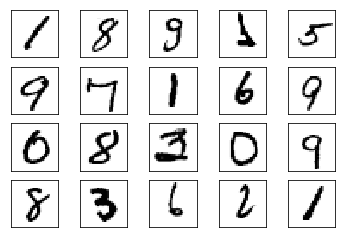

In [5]:
X = pd.read_csv("usps_digit_recognizer.csv")
X = X.values[:,1:]

nrows = 4
ncols = 5
# number of subplots
N1 = int(nrows*ncols)

fig,ax = plt.subplots(nrows=nrows, ncols=ncols)




# loop over all supblots
for n in range(N1):
    
    # get axis indicies for subplot
    i,j = divmod(n,ncols)
    
    x = X[n*20,:].reshape([28,28])
    

    ax[i,j].imshow(x, cmap='Greys')
    
    # clean 
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    


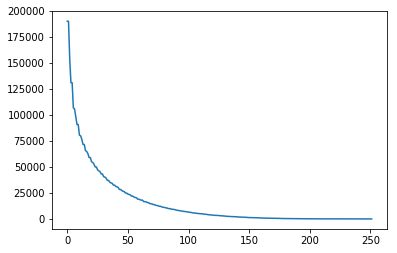

In [6]:
y=np.array(train.label)
x=train.drop('label', axis=1)
x=np.array(x)

N,D=x.shape
K=len(set(y))

M=100
w1 = np.random.randn(D,M)
b1 = np.random.randn(M)
w2 = np.random.randn(M,K)
b2 = np.random.randn(K)


eta0=5e-4 #innitializing eta the learning rate
epsilon=1e-10 #to make sure we donot divide by zero
gt1=1
gt2=1
gtb1=1
gtb2=1

check=100
batch_size=100
t=0
gamma=0.9992
epochs=100

J_D=[]

Y=one_hot_encode(y)

for epoch in range(epochs):
    x,Y,y=shuffle(x,Y,y)
    for j in range(int(N/batch_size)):
        
        #batches=[int((j*N)/batch_size): int((j+1)*N/batch_size)]
        x_b=x[int((j*N)/batch_size) : int((j+1)*N/batch_size),:]
        Y_b=Y[int((j*N)/batch_size) : int((j+1)*N/batch_size),:]
        t+=1
        
        eta1=eta0/np.sqrt(gt1+epsilon)
        eta2=eta0/np.sqrt(gt2+epsilon)
        etab1=eta0/np.sqrt(gtb1+epsilon)
        etab2=eta0/np.sqrt(gtb2+epsilon)
        
        z_b, p_hat_b=feed_forward(x_b,w1,b1,w2,b2)


        dH2 = p_hat_b-Y_b
        dw2 = np.matmul(z_b.T,dH2)
        db2 = dH2.sum(axis = 0)
        w2 -= eta2*dw2
        b2 -= etab2*db2

        dz = np.matmul(dH2,w2.T)
        dH1 = dz*(z_b > 0)
        dw1 = np.matmul(x_b.T,dH1)
        db1 = dH1.sum(axis = 0)
        w1 -= eta1*dw1
        b1 -= etab1*db1
        
        gt1 =gamma*gt1+(1-gamma)*(dw1)**2
        gt2 =gamma*gt2+(1-gamma)*(dw2)**2 
        gtb1 =gamma*gtb1+(1-gamma)*(db1)**2
        gtb2=gamma*gtb2+(1-gamma)*(db2)**2

        if t%check==0:
            p_hat=feed_forward(x,w1,b1,w2,b2)[-1]
            J_D.append(cross_entropy(Y,p_hat))
            
            
plt.figure()
plt.plot(J_D)

In [7]:
accuracy(y,p_hat)

1.0

In [17]:
xv=validation.drop("label", axis=1)
yv=np.array(validation.label)
xv=np.array(xv)
p_hatv=feed_forward(xv,w1,b1,w2,b2)[-1]
accuracy(yv,p_hatv)

0.9285714285714286

In [18]:
xt=test.drop("label", axis=1)
yt=np.array(test.label)
xt=np.array(xt)
p_hatt=feed_forward(xt,w1,b1,w2,b2)[-1]
accuracy(yt,p_hatt)

0.9304761904761905

In [19]:
conf=one_hot_encode(yt).T.dot(one_hot_encode(p_hatt.argmax(axis=1)))

In [20]:
conf=pd.DataFrame(conf)
cc=np.zeros(10)
for i in range(10):
    cc[i]=(conf.loc[i,:].sum()-conf.loc[i,i])/conf.loc[i,:].sum()
    
conf['%error']=cc*100

In [21]:
conf

,0,1,2,3,4,5,6,7,8,9,%error
0,776.0,0.0,6.0,1.0,0.0,3.0,2.0,2.0,4.0,6.0,3.000000
1,0.0,903.0,2.0,1.0,2.0,4.0,0.0,0.0,8.0,3.0,2.166847
2,5.0,7.0,803.0,17.0,6.0,6.0,8.0,8.0,14.0,2.0,8.333333
3,4.0,2.0,18.0,808.0,4.0,19.0,4.0,3.0,13.0,8.0,8.493771
4,2.0,1.0,7.0,0.0,766.0,3.0,8.0,8.0,6.0,24.0,7.151515
5,10.0,0.0,2.0,21.0,6.0,687.0,9.0,1.0,24.0,9.0,10.663199
6,4.0,1.0,3.0,1.0,9.0,12.0,756.0,1.0,5.0,1.0,4.665826
7,2.0,3.0,7.0,4.0,11.0,0.0,1.0,829.0,1.0,21.0,5.688282
8,4.0,6.0,9.0,18.0,5.0,11.0,8.0,4.0,730.0,10.0,9.316770
9,3.0,0.0,3.0,12.0,32.0,6.0,0.0,21.0,12.0,758.0,10.507674


In [12]:
J_D[-1]

1.8409636248436638